<a id='home'></a>

__purpose__ : run kmeans clustering to identify PCA groups for interior Douglas-fir

__conclusions__ : because of the some geographic overlap among groups, we'll use geography to inform color-coding of population groups when visualizing data

## outline

1. [read in snps](#snps)
1. [use k-means clustering to determine population color](#kmeans)
    - Run pca, choose number of axes (based on % variance explained) to use in k-means clustering
    - run k-means clustering for k in {1..21}, choose optimal k based on silhouette method + elbow rule
    - plot populations on map using PCA group colors
    - compare to pca with imputed data

In [1]:
from pythonimports import *
from matplotlib.colors import rgb2hex, colorConverter
import matplotlib.colors as mcolors
import seaborn as sns
sns.set()
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

lview,dview = get_client()

latest_commit()
sinfo(html=True)

56 56
##################################################################
Current commit of pythonimports:
commit 20b1f40f7096065a45a44508a3d1c9ec81588a2e  
Author: Brandon <brandon.lind@ubc.ca>  
Date:   Wed Jun 30 11:47:39 2021 -0600
Today:	July 05, 2021 - 13:33:32
python version: 3.8.5
##################################################################



In [2]:
# read in envdata for lat/long
envfile = '/data/projects/pool_seq/environemental_data/change_p6/df_interior-naturalpops_raw_env-19variables_change-p6.txt'
envdata = pd.read_table(envfile)
envdata.index = envdata['our_id'].tolist()
groupdict = dict(zip(envdata['our_id'], envdata['group']))

colortrans = dict(zip(['#e31a1c', '#22ff00', '#060606', '#f205f4', '#00ecff', '#995bbe'],
                      ['red', 'lime', 'black', 'magenta', 'cyan', 'purple']))
popcolors = dict((pop, colortrans[hexx]) for (pop,hexx) in envdata['group_color'].items())
coldict = popcolors
envdata.head(2)

,prov,our_id,Variety,LONG,LAT,Elevation,MAT,MWMT,MCMT,TD,MAP,MSP,AHM,SHM,DD_0,DD5,NFFD,bFFP,eFFP,FFP,PAS,EMT,EXT,Eref,CMD,group,group_color
DF_p3,3,DF_p3,FDI,-115.62,50.54,1525,1.6,13.4,-10.7,24.1,630,321,18.5,41.8,1242,929,130,171,244,73,261,-43.3,32.6,548,151,Eastern BC,#22ff00
DF_p4,4,DF_p4,FDI,-122.33,52.04,900,3.9,15.3,-9.2,24.5,423,196,32.9,78.2,919,1270,158,154,255,101,149,-40.2,34.9,598,350,North BC,#f205f4


<a id='snps'></a>
# read in snps

[top](#home)

In [3]:
# get imputed allele frequencies
freqfile = '/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety_without-p6/03_maf-p05_RD-recalculated_FDI/rda/DF_pooled-varscan_all_bedfiles_SNP_FDI_maf_RD-recalculated_IMPUTED_nontransformed.pkl'
freqs = pklload(freqfile)
freqs = freqs.T
freqs.head()

,jcf7190000000000-77657,jcf7190000000000-77738,jcf7190000000000-77764,jcf7190000000004-54349,jcf7190000000004-54418,jcf7190000000004-54505,jcf7190000000004-54540,jcf7190000000004-54623,jcf7190000000004-54643,jcf7190000000004-54644,jcf7190000000004-54649,jcf7190000000004-54700,jcf7190000000004-54714,jcf7190000000004-54767,jcf7190000000004-54786,jcf7190000000004-54872,jcf7190000000004-54939,jcf7190000000004-54984,jcf7190000000004-54991,jcf7190000000004-54998,jcf7190000000004-55010,jcf7190000000004-55035,jcf7190000000004-55083,jcf7190000000004-55107,jcf7190000000004-55111,jcf7190000000004-55162,jcf7190000000004-55175,jcf7190000000004-55210,jcf7190000000004-55256,jcf7190000000004-55269,jcf7190000000004-55293,jcf7190000000004-55345,jcf7190000000004-55503,jcf7190000000004-55528,jcf7190000000004-55573,jcf7190000000004-55704,jcf7190000000004-55714,jcf7190000000004-55812,jcf7190000000004-55824,jcf7190000000004-55840,jcf7190000000004-55871,jcf7190000000004-55895,jcf7190000000004-56095,jcf7190000000004-56101,jcf7190000000004-56152,jcf7190000000004-56179,jcf7190000000004-56230,jcf7190000000004-56265,jcf7190000000004-56444,jcf7190000000004-56472,...,jcf7190016526565-25372,jcf7190016526565-25376,jcf7190016526565-25384,jcf7190016526565-25388,jcf7190016526565-25436,jcf7190016526565-25438,jcf7190016526565-25444,jcf7190016526565-25479,jcf7190016526565-32635,jcf7190016526565-32637,jcf7190016526565-32698,jcf7190016526565-32702,jcf7190016526565-32717,jcf7190016526565-32735,jcf7190016526565-32785,jcf7190016526565-32829,jcf7190016526565-32886,jcf7190016526565-32938,jcf7190016526565-32949,jcf7190016526565-33000,jcf7190016526567-46394,jcf7190016526567-46424,jcf7190016526567-46560,jcf7190016526567-46753,jcf7190016526567-46884,jcf7190016526567-46922,jcf7190016526567-47062,jcf7190016526567-47073,jcf7190016526567-47374,jcf7190016526567-47394,jcf7190016526567-47471,jcf7190016526567-47539,jcf7190016526567-47540,jcf7190016526567-47648,jcf7190016526567-47773,jcf7190016526567-47855,jcf7190016526567-47906,jcf7190016526567-47959,jcf7190016526567-47972,jcf7190016526567-48029,jcf7190016526567-48162,jcf7190016526567-48224,jcf7190016526567-48240,jcf7190016526567-48337,jcf7190016526567-48521,jcf7190016526567-48524,jcf7190016526567-48549,jcf7190016526567-48911,jcf7190016526567-48941,jcf7190016526567-48974
DF_p18,0.814000,0.75000,0.8966,0.63640,0.5897,0.18750,0.7255,0.052600,0.3214,0.8070,0.074100,0.8750,0.142925,0.0426,0.1509,0.23400,0.6562,0.259300,0.7241,0.8400,0.8519,0.8400,0.9231,0.9615,0.9630,0.9000,0.0625,0.8214,0.8049,0.307700,0.04080,0.8983,0.2603,0.9014,0.9286,0.2188,0.2985,0.0851,0.2041,0.8696,0.1818,0.1360,0.122800,0.1455,0.1864,0.1667,0.134225,0.7576,0.8065,0.8125,...,0.7727,0.7619,0.9524,1.0000,0.8421,0.8421,0.8000,0.8571,0.7059,0.7059,0.9130,0.9048,0.9259,0.8846,0.7692,0.7692,0.7647,1.0000,0.8571,0.9167,0.750000,1.00000,0.9200,0.5319,0.000000,0.5412,0.8817,0.9140,0.9556,0.9506,0.5395,0.000000,0.5062,0.9326,0.9565,0.0000,0.0120,0.5769,0.0000,0.9178,0.2424,0.9344,0.9672,0.9649,0.4000,0.9833,0.9848,0.9500,0.9286,1.000000
DF_p19,0.823500,0.92590,1.0000,0.72730,0.6316,0.15870,0.8986,0.206300,0.1228,0.9655,0.210500,0.9672,0.215400,0.1389,0.1486,0.13560,0.8750,0.244400,0.8571,0.8718,0.8919,0.9062,0.9375,0.9259,0.9259,0.7812,0.0000,0.7500,0.8462,0.142125,0.05450,0.9571,0.1481,0.9036,0.9277,0.1765,0.1644,0.0000,0.1250,0.9677,0.2154,0.2857,0.125000,0.1375,0.3059,0.2632,0.164200,0.7660,0.9778,0.9783,...,0.9643,0.9615,0.9286,1.0000,0.9091,0.9091,0.8824,0.9286,0.8125,0.8125,1.0000,1.0000,1.0000,1.0000,0.8596,0.8571,0.8710,1.0000,1.0000,1.0000,0.833300,0.92860,0.9355,0.4343,0.047725,0.3214,0.8571,0.8646,0.8974,0.9115,0.3818,0.000000,0.3846,0.9239,0.9400,0.0000,0.0256,0.3364,0.0000,0.8557,0.5395,0.8551,0.9077,0.7971,0.4744,0.8831,0.8734,0.9714,0.8750,1.000000
DF_p20,0.824025,0.84685,0.9427,0.75000,0.7368,0.31925,0.8667,0.197225,0.2593,0.8462,0.196175,0.8529,0.085700,0.0000,0.1053,0.04170,0.8000,0.228025,0.6667,0.6923,0.6154,0.6429,0.8235,0.9412,0.9474,1.0000,0.0000,0.9

In [4]:
# get list of loci with no missing data
nm_file = op.join(op.dirname(freqfile),
                  'DF_pooled-varscan_all_bedfiles_SNP_FDI_maf_RD-recalculated_nomissing-loci-list.txt')
locidf = pd.read_table(nm_file)
nm_loci = locidf['no_missing_loci'].tolist()
len(nm_loci)

641305

In [5]:
# make sure all nm loci are in freqs
assert len(set(nm_loci).intersection(freqs.columns)) == len(nm_loci)

In [6]:
# create subset of freqs using no missing loci
nm_freqs = freqs[nm_loci]

# functions

In [7]:
# map arbitrary pca group to a color, for plotting
coldict = {'first': 'blue',
           'second': 'green',
           'third': 'darkorange',
           'fourth': 'magenta',
           'fifth': 'yellow',
           'sixth': 'saddlebrown',
           'seventh': 'darkgreen',
           'eighth': 'gold',
           'nineth': 'aqua',
           'tenth': 'blueviolet',
           'eleventh': 'pink',
           'twelfth': 'black'}

In [8]:
def get_pca_scores(data, n_components=None):
    """Run principal component analysis."""
    pca = PCA(n_components=n_components)
    pca.fit(data)
    scores_pca = pca.transform(data)
    scores_df = pd.DataFrame(scores_pca, index=data.index)
    return scores_pca, scores_df, pca

def plot_2d_pca(kmeansdata, pca_scores, pca, axes=[0,1], label_pops=False, saveloc=None, basename=''):
    """Plot 2D PCA using `axes`.
    
    Parameters
    ----------
    pca - of type sklearn.decomposition._pca.PCA
    pca_scores - output from pca.transform(data)
    `axes` list of the two axes to plot the PCA. These are the colnames in pca_scores, assumed that
        axis = axes+1 (eg axes=[0,1] is PC1 and PC2)
    label_pops : bool; if True, add population labels (kmeansdata.index)
    """
    plt.figure(figsize=(8,8))
    for name, label in zip(kmeansdata['Segment'], kmeansdata['Segment K-means PCA']):
        plt.scatter(pca_scores[kmeansdata['Segment K-means PCA']==label, axes[0]],
                    pca_scores[kmeansdata['Segment K-means PCA']==label, axes[1]],
                    label=name, c=coldict[name], edgecolor='k', s=40)
    varexp_x, varexp_y = [round(pca.explained_variance_ratio_[i], 4)*100 for i in axes]
    plt.xlabel(f'PC{axes[0]+1} ({varexp_x}%)')
    plt.ylabel(f'PC{axes[1]+1} ({varexp_y}%)')
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend([by_label[key] for key in coldict if key in kmeansdata['Segment']],
               [key for key in coldict if key in kmeansdata['Segment']])

    if label_pops is True:
        component_1 = 'Component %s' % str(axes[0]+1)
        component_2 = 'Component %s' % str(axes[1]+1)
        for pop in kmeansdata.index:
            xcoord,ycoord = kmeansdata.loc[pop, [component_1, component_2]]
            plt.annotate(pop, (xcoord, ycoord), color='k')  # weight='bold'

    if saveloc is not None:
        file = op.join(saveloc,
                       f'{basename}axes-%s_poplabels-%s.pdf' % ('-'.join(map(str, axes)),
                                                                'True' if label_pops is True else 'False'))
        with PdfPages(file) as pdf:
            pdf.savefig(bbox_inches="tight")
        print(ColorText('Saved figure to: ').bold(), file)
    plt.show()
    
    return by_label

def plot_3d(data, colordict, axes=[0,1,2], **kwargs):
    from mpl_toolkits.mplot3d import Axes3D
    from matplotlib.lines import Line2D
    
    cols = [data.columns[axis] for axis in axes]
    scores_df = data[cols]
    
    fig = plt.figure(1, figsize=(10, 7))
    plt.clf()
    ax = Axes3D(fig, **kwargs)

    for pop,segment in data['Segment'].items():
        ax.scatter(*scores_df.loc[pop,cols], c=colordict[segment],
                   s=60, alpha=1, label=segment, edgecolor='k')

    plt.legend([by_label[key] for key in coldict if key in data['Segment']],
               [key for key in coldict if key in data['Segment']])
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')

    plt.show()
    pass

def plot_pca(pca, scores, n_components=None):
    # plot cumulative variance explaned
    num_axes = len(scores) if n_components is None else n_components
    plt.plot(range(1, num_axes + 1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
    plt.xlabel('PC axis')
    plt.ylabel('cumulative variance explained')
    plt.show()
    # second variance explained per axis
    features = range(pca.n_components_)
    fig = plt.figure(figsize=(15,5))
    plt.bar(features, pca.explained_variance_ratio_, color='black')
    plt.xlabel('PCA features')
    plt.ylabel('variance %')
    plt.xticks(features)
    plt.show()
    pass

In [9]:
def pipeline(freqdata, n_components=None, label_pops=False, k=None, saveloc=None, bmkwargs={},
             longcol='LONG', latcol='LAT', show_variance=True, basename=''):
    """Run pca, get_pca_scores, and plot_2d_pca; return pca results.
    
    n_components - number of PCA components to use in k-means clustering
        - use 'all' when prompted to choose all components
    label_pops - bool; label PCA plots if True else don't
    k - number of k-means groups; if None, code will prompt user
    saveloc - location to save PCA plots
    bmkwargs - kwargs to myslurm.basemap
    longcol - column name in envdata that has longitude
    latcol - column name in envdata that has latitude
    show_variance - whether to show the variance explained by PC axes
    """
    # do PCA
    scores,df,pca = get_pca_scores(freqdata, n_components=n_components)
    if show_variance is True:
        plot_pca(pca, scores, n_components=n_components)
    # choose how many PCA axes to use
    if n_components is None:
        while True:
            print('how many components do you want to use?')
            n_components = int(input())
            if int(n_components) == float(n_components) or n_components.lower() == 'all':
                break
        if n_components == 'all':
            n_components = None
        else:
            print(ColorText(f'\nAfter choosing {n_components} PCA components: ').bold().green())
            scores,df,pca = get_pca_scores(freqdata, n_components=n_components)
            plot_pca(pca, scores, n_components=n_components)
    
    # identify best number of k-means groups, `k`
    if k is None:
        print(ColorText('Choosing k ...').bold())
        wcss = []
        for i in range(2, 21):
            kmeans_pca = KMeans(n_clusters=i, init='k-means++')
            kmeans_pca.fit(scores)
            cluster_labels = kmeans_pca.predict(scores)  # necessary for average silhouette method
            silhouette_avg = silhouette_score(scores, cluster_labels)
            print(f"For n_clusters = {i} the average silhouette_score is :", silhouette_avg)
            wcss.append(kmeans_pca.inertia_)
        plt.plot(range(2,21), wcss, marker='o', linestyle='--')
        plt.xlabel('Number of clusters')
        plt.ylabel('Within-cluster sum of squares')
        plt.show()
        while True:
            print('what do you want `k` to be?')
            k = int(input())
            if int(k) == float(k):
                break

    # get kmeans
    # use random state so the clusters are named the same each time
    kmeans_pca = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans_pca.fit(scores)
    
    data = pd.concat([freqdata, pd.DataFrame(scores, index=freqdata.index)], axis=1)
    data.columns.values[-n_components:] = [f'Component {i+1}' for i in range(n_components)]
    data['Segment K-means PCA'] = kmeans_pca.labels_
    transdict = dict(zip(
        list(range(len(keys(coldict)))),
        keys(coldict)
    ))
    data['Segment'] = data['Segment K-means PCA'].map(transdict)
    
    for axes in [[0,1], [0,2], [1,2]]:
        plot_2d_pca(data, scores, pca, axes=axes, label_pops=label_pops, saveloc=saveloc, basename=basename)
        if n_components == 2:
            break

    # map pop to color
    popcolors = dict(zip(data.index, data['Segment'].map(coldict)))
    
    # plot k-means groups on a map
    ax = basemap(**bmkwargs)

    for pop in envdata.index:
        long,lat = envdata.loc[pop, [longcol, latcol]]
        draw_pie_marker([1,0],
                        long,
                        lat,
                        200,
                        ax=ax,
                        colors=[popcolors[pop]],
                        label=pop if label_pops is True else None,
                        zorder=1000,
                        transform=True)
    
    # save map
    if saveloc is not None:
        file = op.join(
            saveloc,
            f'{basename}map_axes-{n_components}_k-{k}_labels-%s.pdf' % ('True' if label_pops is True else 'False')
        )
        print(ColorText('Saved figure to: ').bold(), file)
        with PdfPages(file) as pdf:
            pdf.savefig(bbox_inches="tight")
    plt.show()
    
    return data

<a id='kmeans'></a>
# use k-means clustering to determine population color

[top](#home)

In [10]:
# kwargs for `basemap`
intrange = '/data/projects/pool_seq/environemental_data/shapefiles/Interior_DF.shp'
bmkwargs = dict(extent=[-130, -112.5, 37.5, 55.5],
                shapefiles=[('purple', intrange)])

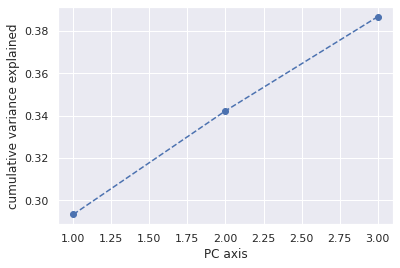

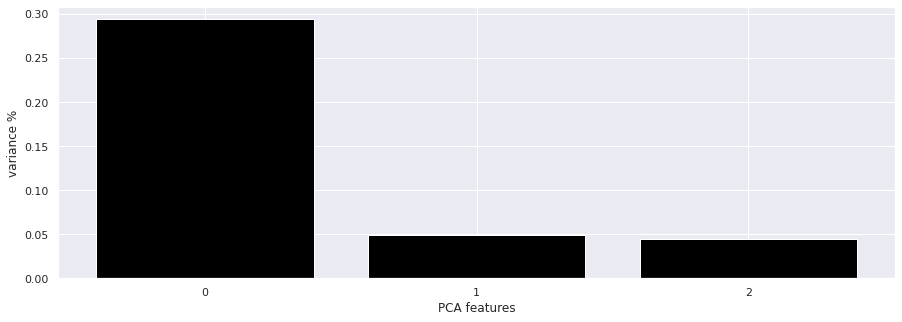

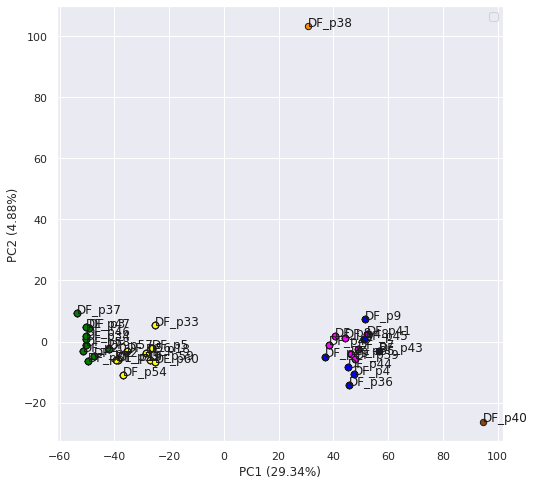

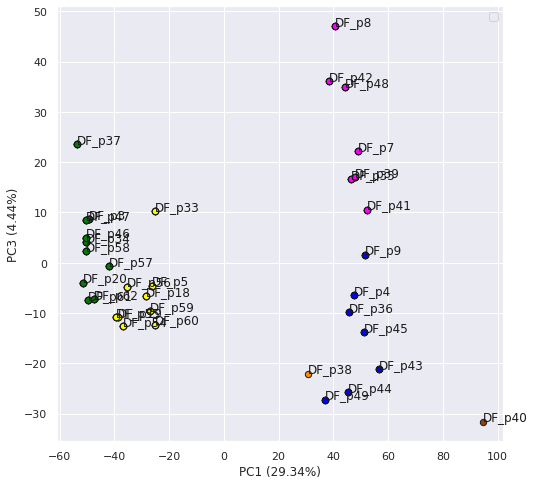

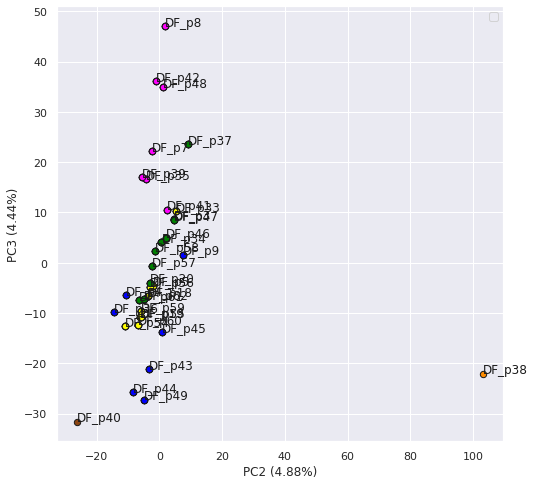

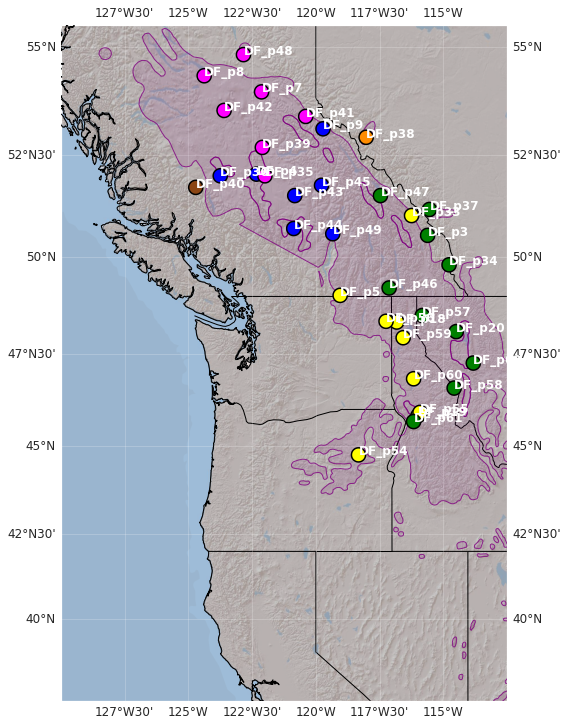

In [11]:
# save figures with labels
# the error can be ignored, `pipeline` completed
savedir = '/lu213/brandon.lind/data/testdir'
data = pipeline(
    nm_freqs.copy(), label_pops=True, bmkwargs=bmkwargs, basename='no-missing_', n_components=3, k=6
)

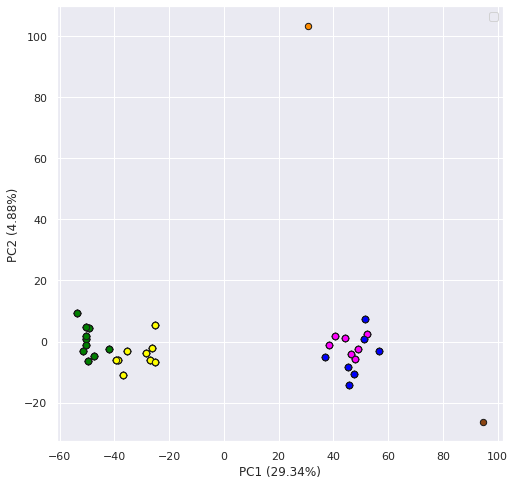

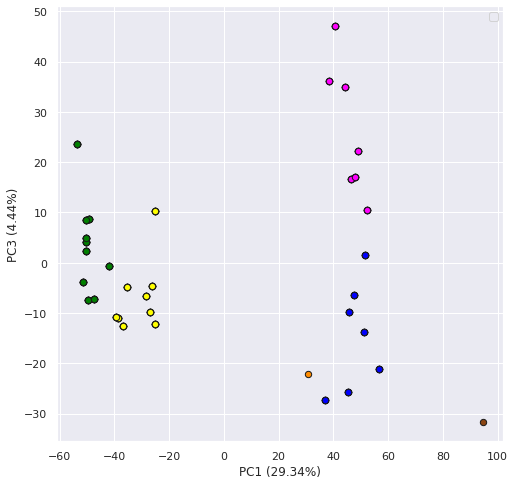

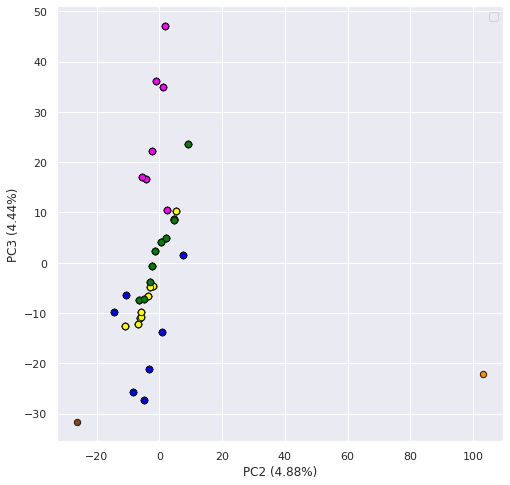

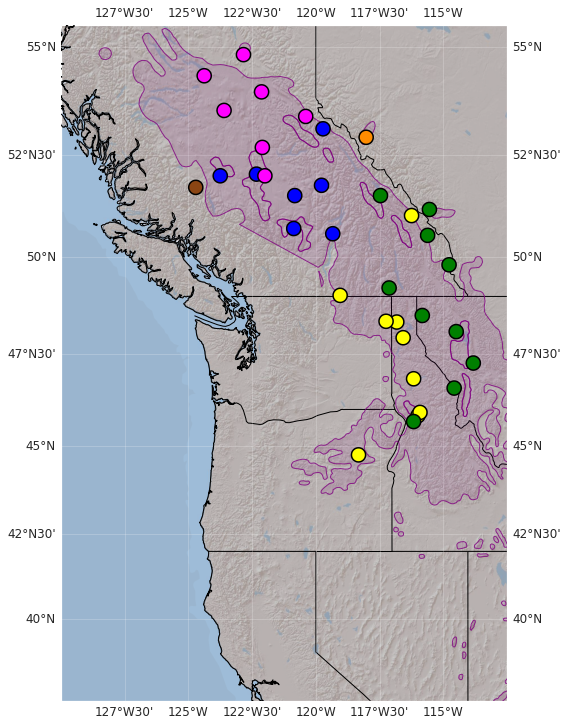

In [12]:
# save figures with labels
# the error can be ignored, `pipeline` completed
savedir = '/lu213/brandon.lind/data/testdir'
x = pipeline(
    nm_freqs.copy(), label_pops=False, bmkwargs=bmkwargs, basename='no-missing_', n_components=3, k=6,
    show_variance=False
)